In [54]:
import argparse
import numpy as np
from scipy.spatial.transform import Rotation as Rot
import pickle
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from typing import List

import open3d as o3d

# from robot_utils.robot_data.pose_data import PoseData
# from robot_utils.transform import transform_2_xytheta
# from robot_utils.geometry import circle_intersection

# from segment_track.segment import Segment
# from segment_track.tracker import Tracker

from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.object.object import Object
from object_map_registration.object.pointcloud_object import PointCloudObject
from object_map_registration.register.dist_feature_sim_reg import DistOnlyReg, DistVolReg, DistFeaturePCAReg
from object_map_registration.register.dist_reg_with_pruning import DistRegWithPruning, GravityConstraintError
from object_map_registration.register.object_registration import InsufficientAssociationsException
from object_map_registration.utils import object_list_bounds
# from open3d.web_visualizer import draw
# from open3d import JVisualizer

import open3d.visualization as vis

from robot_utils.transform import T_FLURDF


# %matplotlib widget
# %matplotlib inline

In [55]:
poses_1_file =  '/home/masonbp/results/west_point_2023/segment_tracking/rgbd5/1117_02.pkl'
poses_2_file =  '/home/masonbp/results/west_point_2023/segment_tracking/rgbd5/1117_04.pkl'

In [56]:
poses_1 = []
trackers_1 = []
with open(poses_1_file, 'rb') as f:
    t, p = pickle.load(f)
    poses_1.append(p)
    trackers_1.append(t)

In [57]:
poses_2 = []
trackers_2 = []
with open(poses_2_file, 'rb') as f:
    t, p = pickle.load(f)
    poses_2.append(p)
    trackers_2.append(t)

In [58]:
# print(submaps_0[8][0]['centroid'].squeeze())

In [59]:
# len(poses_1[0])

In [60]:
# for i, pose in enumerate(poses_1[0]):
#     # print(submaps_0[8][0]['centroid'].squeeze())
#     # print(pose[:-1,-1])
#     # print(submaps_0[8][0]['centroid'].squeeze() - pose[:-1,-1])
#     # print()
#     if np.linalg.norm(submaps_0[8][0]['centroid'].squeeze() + pose[:-1,-1]) < 1e-3:
#         print(pose[:-1,-1])
#         print(i)
#         break

In [61]:
# print(submaps_1[28][0]['centroid'].squeeze())

In [62]:
# for i, pose in enumerate(poses_2[0]):
#     # print(submaps_0[8][0]['centroid'].squeeze())
#     # print(pose[:-1,-1])
#     # print(submaps_0[8][0]['centroid'].squeeze() - pose[:-1,-1])
#     # print()
#     if np.linalg.norm(submaps_1[28][0]['centroid'].squeeze() + pose[:-1,-1]) < 1e-3:
#         print(pose[:-1,-1])
#         print(i)
#         break

Loaded 21 and 34 submaps.


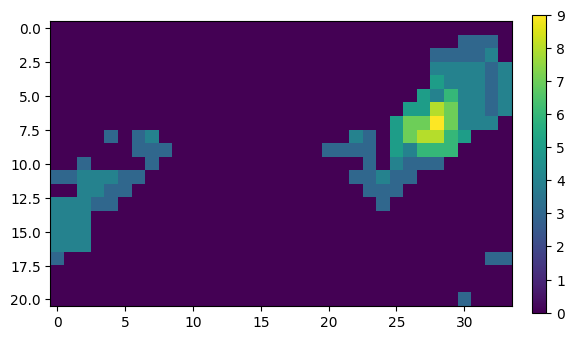

In [63]:
# output_viz_file = '/home/yulun/code/segment_track/outputs/distfeatpca_output_viz.pkl'
output_viz_file = '/home/masonbp/results/west_point_2023/segment_align/12_wp/02/extentvolgrav.viz.pkl'
pkl_file = open(output_viz_file, 'rb')
submaps_0, submaps_1, associated_objs_mat, robots_nearby_mat, T_ij_mat, T_ij_hat_mat = pickle.load(pkl_file)
pkl_file.close()
print(f'Loaded {len(submaps_0)} and {len(submaps_1)} submaps.')
clipper_num_associations  =  np.zeros((len(submaps_0), len(submaps_1)))*np.nan

# Find submaps where most associations occur.
max_i = 0
max_j = 0
max_num = 0
for i in range(len(submaps_0)):
  for j in range(len(submaps_1)):
    clipper_num_associations[i, j] =  len(associated_objs_mat[i][j])
    # if clipper_num_associations[i, j] > 0.0:
    #   print(i, j, clipper_num_associations[i, j])
    if len(associated_objs_mat[i][j]) > max_num:
      max_num = len(associated_objs_mat[i][j])
      max_i = i
      max_j = j

plt.imshow(
  clipper_num_associations, 
  vmin=0, 
)
plt.colorbar(fraction=0.03, pad=0.04)
plt.show()

In [64]:
# Same dir
# idx_0 = max_i
# idx_1 = max_j
idx_0 = 8
idx_1 = 28

# Opposite dir


association = associated_objs_mat[idx_0][idx_1]
submap_0 = [PointCloudObject.from_pickle(data) for data in submaps_0[idx_0]]
submap_1 = [PointCloudObject.from_pickle(data) for data in submaps_1[idx_1]]
print(f'Submap pair ({idx_0}, {idx_1}) contains {len(submap_0)} and {len(submap_1)} objects.')
print(f'Clipper finds {len(association)} associations.')


Submap pair (8, 28) contains 65 and 56 objects.
Clipper finds 8 associations.


In [65]:
# submaps_0[idx_0][7]

In [66]:
# submaps_1[idx_1][35]

In [67]:
# for i in range(len(submaps_0[idx_0])):
#     if submaps_0[idx_0][i]['id'] in [3947, 4067, 4057, 4451, 4450]:
#         print(i, submaps_0[idx_0][i]['id'])

In [68]:
# for i in range(len(submaps_1[idx_1])):
#     if submaps_1[idx_1][i]['id'] in [7565, 7567, 7528, 7395]:
#         print(i, submaps_1[idx_1][i]['id'])

In [69]:
# Prepare submaps for visualization
ocd_list_0 = []
ocd_list_1 = []
edges = []
red_color = np.asarray([1,0,0]).reshape((1,3))
blue_color = np.asarray([0,0,1]).reshape((1,3))
for seg in submap_0:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(seg.get_points())
  num_pts = seg.get_points().shape[0]
  rand_color = np.random.uniform(0, 1) * red_color
  rand_color = np.repeat(rand_color, num_pts, axis=0)
  pcd.colors = o3d.utility.Vector3dVector(rand_color)
  ocd_list_0.append(pcd)
  # print(pcd.get_center())

for seg in submap_1:
  pcd = o3d.geometry.PointCloud()
  pcd.points = o3d.utility.Vector3dVector(seg.get_points())
  num_pts = seg.get_points().shape[0]
  rand_color = np.random.uniform(0, 1) * blue_color
  rand_color = np.repeat(rand_color, num_pts, axis=0)
  pcd.colors = o3d.utility.Vector3dVector(rand_color)
  pcd.translate(np.asarray([0,-30,0]))
  ocd_list_1.append(pcd)

for obj_idx_0, obj_idx_1 in association:
  print(f'Add edge between {obj_idx_0} and {obj_idx_1}.')
  points = [ocd_list_0[obj_idx_0].get_center(), ocd_list_1[obj_idx_1].get_center()]
  line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector([[0,1]]),
  )
  line_set.colors = o3d.utility.Vector3dVector([[0,1,0]])
  # line_set.scale = 5
  # increase width
  edges.append(line_set)

# points = [ocd_list_0[3].get_center(), ocd_list_1[34].get_center()]
# line_set = o3d.geometry.LineSet(
#   points=o3d.utility.Vector3dVector(points),
#   lines=o3d.utility.Vector2iVector([[0,1]]),
# )
# line_set.colors = o3d.utility.Vector3dVector([[0,1,0]])
# edges.append(line_set)


Add edge between 19 and 36.
Add edge between 15 and 41.
Add edge between 24 and 28.
Add edge between 7 and 35.
Add edge between 22 and 31.
Add edge between 5 and 39.
Add edge between 44 and 10.
Add edge between 35 and 19.


In [70]:
pose_prev = poses_1[0][1387]
translation_prev = -pose_prev[:-1, -1]
print(translation_prev)

[-19.65482305 -43.77853952  -3.09657025]


In [71]:
len(poses_1[0])

3198

In [72]:
# poses_0 = []
edges1 = []
for i in range(1000, 1600, 20):
    pose_prev = poses_1[0][i]
    translation_prev = pose_prev[:-1, -1] - poses_1[0][1387][:-1, -1]

    pose_next = poses_1[0][i+1]
    translation_next = pose_next[:-1, -1] - poses_1[0][1387][:-1, -1]

    points = [translation_prev, translation_next]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector([[0,1]]),
    )

    pose_obj = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
    resulting_pose = poses_1[0][i]
    pose_next = poses_1[0][i+1]
    translation_next = pose_next[:-1, -1] - poses_1[0][1387][:-1, -1] + [0, -30, 0]
    resulting_pose[:-1,-1] = translation_prev
    resulting_pose = resulting_pose @ np.linalg.inv(T_FLURDF)
    pose_obj.transform(resulting_pose)
    edges1.append(pose_obj)

    if i % 20 == 0:

        vec_len = 1.0
        mesh_arrow = o3d.geometry.TriangleMesh.create_arrow(
            cone_height= 0.4 * vec_len, 
            cone_radius= 0.3 * vec_len, 
            cylinder_height= 0.8 * vec_len,
            cylinder_radius=  0.1 * vec_len
            )
        mesh_arrow.paint_uniform_color([1,0,1])
        mesh_arrow.compute_vertex_normals()
        mesh_arrow.translate(translation_prev)
        mesh_arrow.rotate(Rot.from_matrix(pose_prev[:3, :3]).as_matrix(), center=translation_prev)
        mesh_arrow.paint_uniform_color([247/(247+143+7), 143/(247+143+7), 7/(247+143+7)])

        # edges1.append(mesh_arrow)

    
    line_set.colors = o3d.utility.Vector3dVector([[247/(247+143+7), 143/(247+143+7), 7/(247+143+7)]])
    # edges1.append(line_set)


In [73]:
# poses_0 = []
edges2 = []
for i in range(3750, 4600, 20):
    pose_obj = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
    resulting_pose = poses_2[0][i]

    pose_prev = poses_2[0][i]
    translation_prev = pose_prev[:-1, -1] - poses_2[0][4213][:-1, -1] + [0, -30, 0]

    pose_next = poses_2[0][i+1]
    translation_next = pose_next[:-1, -1] - poses_2[0][4213][:-1, -1] + [0, -30, 0]
    resulting_pose[:-1,-1] = translation_prev
    resulting_pose = resulting_pose @ np.linalg.inv(T_FLURDF)
    pose_obj.transform(resulting_pose)
    edges2.append(pose_obj)

    points = [translation_prev, translation_next]
    line_set = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(points),
        lines=o3d.utility.Vector2iVector([[0,1]]),
    )
    line_set.colors = o3d.utility.Vector3dVector([[7/(7+187+247), 187/(7+187+247), 247/(7+187+247)]])
    # edges2.append(line_set)

    # if i % 20 == 0:

    #     vec_len = 1.0
    #     mesh_arrow = o3d.geometry.TriangleMesh.create_arrow(
    #         cone_height= 0.4 * vec_len, 
    #         cone_radius= 0.3 * vec_len, 
    #         cylinder_height= 0.8 * vec_len,
    #         cylinder_radius=  0.1 * vec_len
    #         )
    #     mesh_arrow.paint_uniform_color([1,0,1])
    #     mesh_arrow.compute_vertex_normals()
    #     mesh_arrow.translate(translation_prev)
    #     mesh_arrow.rotate(Rot.from_matrix(pose_prev[:3, :3]).as_matrix(), center=translation_prev)
    #     mesh_arrow.paint_uniform_color([7/(7+187+247), 187/(7+187+247), 247/(7+187+247)])

        # edges1.append(mesh_arrow)



Add edge between 24 and 28.
Add edge between 19 and 36.
Add edge between 22 and 31.
Add edge between 15 and 41.
Add edge between 7 and 35.
Add edge between 44 and 10.
Add edge between 35 and 19.

In [74]:
# for d in o3d.visualization.rendering.__dir__():
#     print(d)
# mat = o3d.visualization.rendering.Material()
# mat.shader = "unlitLine"
# mat.line_width = 10  # note that this is scaled with respect to pixels,
# vis.draw_geometries(ocd_list_0 + ocd_list_1 + edges + edges1 + edges2, material=mat)


In [75]:
vis.draw_geometries(ocd_list_0 + ocd_list_1 + edges + edges1 + edges2)


In [76]:
# vis = o3d.visualization.Visualizer()
# vis.create_window()
# for thing in ocd_list_0 + ocd_list_1 + edges + edges1 + edges2:
#     vis.add_geometry(thing)
# vis.get_render_option().line_width = 10000
# vis.get_render_option().point_size = 1
# vis.run()

In [77]:
# ctr = vis.get_view_control()
# print("Field of view (before changing) %.2f" % ctr.get_field_of_view())
# ctr.change_field_of_view(step=0.)
# vis3d = o3d.visualization.Visualizer()
# vis3d.create_window()
# vis3d.add_geometry(ocd_list_0 + ocd_list_1 + edges + edges1 + edges2)
# vis3d.run()
# # vis.draw_geometries(ocd_list_0 + ocd_list_1 + edges)
# # draw(ocd_list_0)
# # draw(ocd_list_0 + ocd_list_1 + edges)
# # vis.show()s